# Analysis of the Text Variables

In [27]:
#from load_data import *

#from helpers import clean_comments
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import collections
from langdetect import detect
from deep_translator import GoogleTranslator

from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud

#from textblob import TextBlob

#import transformers
#import shap
from re import sub

In [28]:
def clean_comments(text):
    ''' Pre process and convert texts to a list of words
    method inspired by method from eliorc github repo: https://github.com/eliorc/Medium/blob/master/MaLSTM.ipynb'''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
    text = sub(r"\+", " plus ", text)
    text = sub(r",", " ", text)
    text = sub(r"\.", " ", text)
    text = sub(r"!", " ! ", text)
    text = sub(r"\?", " ? ", text)
    text = sub(r"'", " ", text)
    text = sub(r":", " : ", text)
    text = sub(r"\s{2,}", " ", text)
    text = sub(r"\s+$", "", text)

    # they were weird
    text = text.replace("br/", "")

    return text

In [29]:
url_listing = "http://data.insideairbnb.com/germany/bv/munich/2021-12-24/data/listings.csv.gz"
url_reviews = "http://data.insideairbnb.com/germany/bv/munich/2021-12-24/data/reviews.csv.gz"
listings = pd.read_csv(url_listing)
reviews = pd.read_csv(url_reviews)

## Reviews

clean reviews, detect language (english = 1, else = 0) and translate if necessary

In [30]:
reviews_f = reviews["comments"].apply(lambda x: clean_comments(x))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
langs = []
def det_and_trans(review):
    if len(review) == 0:
        langs.append(1)
        return review
    if not review.islower():
        langs.append(1)
        return review
    det_lan = detect(review)
    check = det_lan == "en"
    if not check:
        translation = GoogleTranslator(source='auto', target='en').translate(review)
        langs.append(0)
        return translation
    else:
        langs.append(1)
        return review

#started at 16:30
for i in range(len(reviews_f)):
    reviews_f[i] = det_and_trans(reviews_f[i])
    print(i)

reviews_df = pd.DataFrame(
    {"reviews": reviews_f,
     "lang": langs
     })


reviews_df.to_csv("trans_reviews_munich.csv")

In [ ]:
reviews_f_read = pd.read_csv("trans_reviews_munich.csv")

# replace NaNs with space
reviews_f = reviews_f_read["reviews"]
for i in range(len(reviews_f)):
    if type(reviews_f[i]) == float:
        reviews_f[i] = " "

langs_df = reviews_f_read["lang"]

# Portion of english reviews?
np.mean(langs_df).round(4) * 100

## Wordcloud

Let's look at some word frequencies

In [62]:
# Word Frequency
def convert(lst):
    return ([i for item in lst for i in item.split()])

all_words_review = convert(reviews_f)

count_word = collections.Counter(all_words_review) #Count word frequency
clean_word_count = pd.DataFrame(count_word.most_common(10),
                             columns=['words', 'count'])

# So let us remove stop words
stop_words = set(stopwords.words(['english']))
# Add some words after analysing
freq_airbnb = ["us", "would", "host", "house", "room", "city", "apartment",
               "location", "dublin", "place", "stay", "de", "also", "munich"]
stop_words.update(freq_airbnb)


# View a few words from the set
list(stop_words)[0:10]

["shan't",
 "that'll",
 'aren',
 "hadn't",
 "needn't",
 'wouldn',
 "mustn't",
 'yours',
 'her',
 'same']

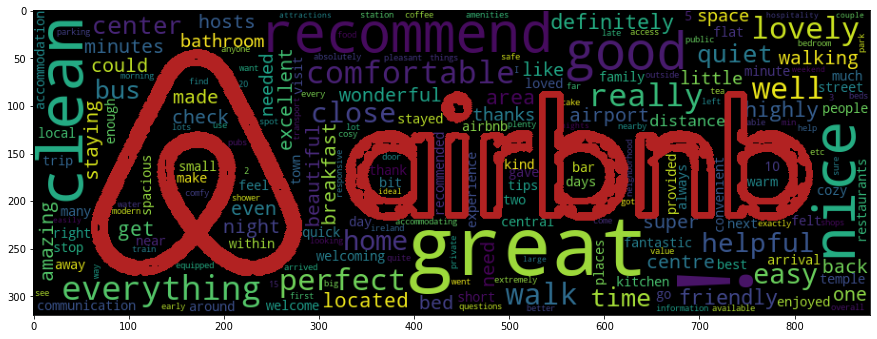

In [63]:
words_review_cleaned = [word for word in all_words_review if word not in stop_words]
words_review_count = collections.Counter(words_review_cleaned)

#mask = np.array(Image.open("AirBnB_Logo.png"))
mask = np.array(Image.open("AirBnB_munich.jpeg"))

wordcloud = WordCloud(width = 1000, height = 500, mask = mask, #background_color="white",
                      contour_width=10, contour_color='firebrick').generate_from_frequencies(words_review_count)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.show()

### Sentiment Analysis

In [64]:
# "no problem(s)" and "no complaints" only was quite negative and special cases do not validate on their own
def no_prob_to_good(review, term):
    if term in review:
        if len(review.split()) < 5:
            review = "We did not have any problems."
    return review

term = "no problem"
for i in range(len(reviews_f)):
    reviews_f[i] = no_prob_to_good(reviews_f[i], term=term)

term = "no complaint"
for i in range(len(reviews_f)):
    reviews_f[i] = no_prob_to_good(reviews_f[i], term=term)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### NLTK

Neutral, Negativity and Positivity sum up to 1 (like how much of what is in it)
Compound is a weighted normalized (-1,1) score of the sum of the valence -> Sentiment of entire text.

In [67]:
# Polarity Scores
sid = SentimentIntensityAnalyzer()
#sid.constants.SPECIAL_CASE_IDIOMS.update({"no problem" : 1.5, "no problems" : 1.5}) # "no problem(s)" was very negative
pscores = [sid.polarity_scores(comment) for comment in reviews_f]

Histograms of different Polarity Scores

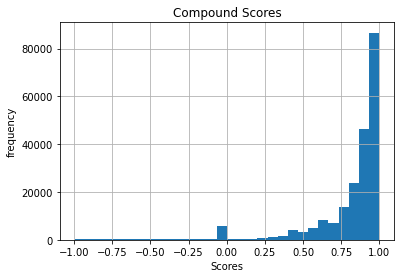

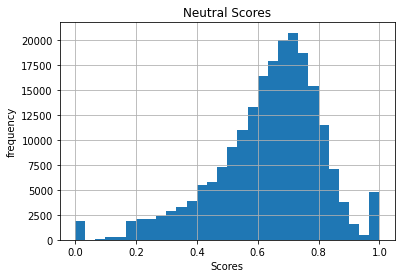

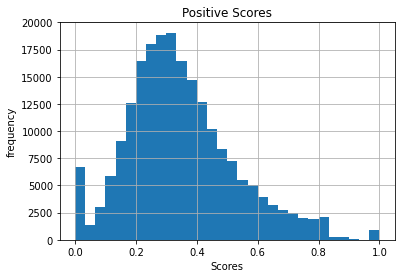

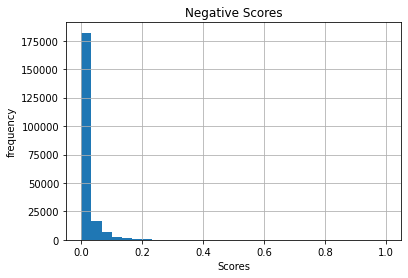

In [68]:
#Histogram plot neutral
pd.Series([score['compound'] for score in pscores]).plot(kind='hist', grid = True, bins = 30)

plt.title('Compound Scores')
plt.xlabel('Scores')
plt.ylabel('frequency')

plt.show()

#Histogram plot neutral
pd.Series([score['neu'] for score in pscores]).plot(kind='hist', grid = True, bins = 30)

plt.title('Neutral Scores')
plt.xlabel('Scores')
plt.ylabel('frequency')

plt.show()

#Histogram plot positive
pd.Series([score['pos'] for score in pscores]).plot(kind='hist', grid = True, bins = 30)

plt.title('Positive Scores')
plt.xlabel('Scores')
plt.ylabel('frequency')

plt.show()

#Histogram plot negative
pd.Series([score['neg'] for score in pscores]).plot(kind='hist', grid = True, bins = 30)

plt.title('Negative Scores')
plt.xlabel('Scores')
plt.ylabel('frequency')

plt.show()

In [69]:
#Create dataframe for sentiment analysis
scored_reviews = pd.DataFrame()
scored_reviews["listing_id"] = reviews["listing_id"]
scored_reviews["english_review"] = langs_df
scored_reviews['review'] = [r for r in reviews_f]
scored_reviews['compound'] = [score['compound'] for score in pscores]
scored_reviews['negativity'] = [score['neg'] for score in pscores]
scored_reviews['neutrality'] = [score['neu'] for score in pscores]
scored_reviews['positivity'] = [score['pos'] for score in pscores]

### Review further

Add length of review, too.
Also it might be interesting how many negative reviews for each listing there are, so create a boolean variable displaying whether there is a negative compound.

In [80]:
scored_reviews["review_length"] = scored_reviews["review"].apply(lambda x: len(x))
scored_reviews["negative_comp"] = scored_reviews["compound"] < 0
del scored_reviews["review"]
scored_reviews

,listing_id,english_review,compound,negativity,neutrality,positivity,review_length,negative_comp
0,44077,1,0.9513,0.108,0.603,0.289,431,False
1,44077,1,0.9820,0.000,0.583,0.417,249,False
2,44077,1,0.9836,0.000,0.736,0.264,481,False
3,44077,1,0.9447,0.048,0.549,0.403,178,False
4,44077,1,0.9835,0.000,0.588,0.412,295,False
...,...,...,...,...,...,...,...,...
211239,52898729,1,0.8817,0.039,0.676,0.286,170,False
211240,52898729,1,0.8906,0.000,0.398,0.602,65,False
211241,52898729,1,0.9703,0.000,0.455,0.545,143,False
211242,52959358,1,0.9549,0.000,0.714,0.286,265,False


Grouping be the id.

In [106]:
listings_reviews_min = scored_reviews.groupby(["listing_id"]).min()
listings_reviews_max = scored_reviews.groupby(["listing_id"]).max()
listings_reviews_mean = scored_reviews.groupby(["listing_id"]).mean()
listings_reviews_sum = scored_reviews.groupby(["listing_id"]).sum()

extr_col = listings_reviews_min["compound"]
extr_col = pd.concat([extr_col, listings_reviews_max["compound"]], axis = 1)
extr_col.columns = ["most_neg_compound", "most_pos_compound"]

# give all the sums a prefix in their column names
listings_reviews_mean = listings_reviews_mean.add_prefix("mean_")

# combine
listings_reviews = pd.concat([listings_reviews_mean, extr_col], axis=1)
listings_reviews.reset_index(inplace=True)
listings_reviews.columns = ["id", "prop_of_eng_reviews", "mean_compound", "mean_negativity", "mean_neutrality", 
                            "mean_positivity", "mean_review_length", "prop_of_neg_comp", "most_neg_compound",
                            "most_pos_compound"]

listings_reviews

,id,prop_of_eng_reviews,mean_compound,mean_negativity,mean_neutrality,mean_positivity,mean_review_length,prop_of_neg_comp,most_neg_compound,most_pos_compound
0,44077,0.859031,0.886258,0.009793,0.670132,0.311251,323.744493,0.000000,0.0000,0.9983
1,85148,1.000000,0.000000,0.000000,1.000000,0.000000,86.000000,0.000000,0.0000,0.0000
2,85156,0.829670,0.903634,0.007324,0.656236,0.336429,314.010989,0.005495,-0.4247,0.9947
3,159889,0.894569,0.814857,0.013380,0.657185,0.326230,256.952077,0.019169,-0.5451,0.9970
4,162809,0.843750,0.850852,0.011899,0.627295,0.360833,253.572917,0.006944,-0.2378,0.9966
...,...,...,...,...,...,...,...,...,...,...
5542,52850962,1.000000,0.811125,0.005750,0.620750,0.373500,312.000000,0.000000,0.3612,0.9824
5543,52879135,1.000000,0.421500,0.000000,0.682000,0.318000,33.000000,0.000000,0.4215,0.4215
5544,52898729,1.000000,0.932400,0.009750,0.548500,0.442000,204.500000,0.000000,0.8817,0.9870
5545,52959358,1.000000,0.954900,0.000000,0.714000,0.286000,265.000000,0.000000,0.9549,0.9549


In [129]:
listings_reviews.to_csv("listings_reviews_munich.csv")

## Further Text

Which are: ["name", "host_name", "description", "neighborhood_overview", "host_about"]
Name - "Name of the listing"
host_name - "Name of the host. Usually just the first name(s)."
description: "Detailed description of the listing"
neighbourhood_overview: "Host's description of the neighbourhood"
host_about: "Description about the host"

All these variables are written by the host (or naturally given, like their name).
It might have an effect how much effort to shine or how much love they put in the
descriptions. So the length could be a proper variable.

Try sentiments at description, neighbourhood_overview and host_about.

In [107]:
text_col = ["name", "host_name", "description", "neighborhood_overview", "host_about"]

listings["name_length"] = listings["name"].apply(lambda x: len(x))
listings["description_length"] = listings["description"].apply(lambda x: len(x))
listings["neighborhood_overview_length"] = listings["neighborhood_overview"].apply(lambda x: len(x))
listings["host_about_length"] = listings["host_about"].apply(lambda x: len(x))

### Sentiment Analysis
of "description", "neighborhood_overview", "host_about"

In [108]:
# Translation and language used by the Host
list_name = listings["name"].apply(lambda x: clean_comments(x))
descr = listings["description"].apply(lambda x: clean_comments(x))
neigh_over = listings["neighborhood_overview"].apply(lambda x: clean_comments(x))
host_ab = listings["host_about"].apply(lambda x: clean_comments(x))


# check if all are english
langs = []
for i in range(len(listings)):
    list_name[i] = det_and_trans(list_name[i])
    descr[i] = det_and_trans(descr[i])
    neigh_over[i] = det_and_trans(neigh_over[i])
    host_ab[i] = det_and_trans(host_ab[i])
    print(i)

list_name_lang = langs[::4]
descr_lang = langs[1::4]
neigh_over_lang = langs[2::4]
host_ab_lang = langs[3::4]

eng_host = []
for i in range(len(descr_lang)):
    lang_sum = list_name_lang[i] + descr_lang[i] + neigh_over_lang[i] + host_ab_lang[i]
    if lang_sum <= 1:
        eng_host.append(0)
    else:
        eng_host.append(1)


host_lang = pd.DataFrame(
    {"list_name": list_name,
     "descr": descr,
     "neigh_over": neigh_over,
     "host_ab": host_ab,
     "eng_host": eng_host
     })

host_lang.to_csv("host_lang_munich.csv")

host_lang = pd.read_csv("host_lang_munich.csv")

for i in range(len(host_lang)):
    if type(host_lang["list_name"][i]) == float:
        host_lang["list_name"][i] = " "
    if type(host_lang["descr"][i]) == float:
        host_lang["descr"][i] = " "
    if type(host_lang["neigh_over"][i]) == float:
        host_lang["neigh_over"][i] = " "
    if type(host_lang["host_ab"][i]) == float:
        host_lang["host_ab"][i] = " "

host_lang


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Unnamed: 0,list_name,descr,neigh_over,host_ab,eng_host
0,0,cosy comfortable irish cottage twin,our house was built in 1937 when there was ple...,i like our neighbourhood as there is no shorta...,i am a friendly outgoing irishwoman who loves ...,1
1,1,cosy comfortable irish cottage 1 double bed,our cottage is a charming light filled cottage...,i love dundrum and its surrounding areas br / ...,i am a friendly outgoing irishwoman who loves ...,1
2,2,friendly single room,washing can be done at a cost of 5 per load br...,plenty of buses into the city and the area is ...,used to host students and now i am looking for...,1
3,3,5 5 miles south of dublin city ^,a nice place to relax after the bustle of the ...,close to the sea hill walks and the city via b...,i live here on the third floor of my house the...,1
4,4,p draig pearse apt kilmainham,don t just visit dublin experience dublin in a...,enjoy a walk along the grand canal or just obs...,i m gr inne originally from co kildare and rai...,1
...,...,...,...,...,...,...
6835,6835,stylish 1 bed in dublin 4 close to all amenities,the apartment is located within a stunning geo...,dublin city,wake up in the comfort of your own home where ...,1
6836,6836,lovely non shared single bedroom,we are a very easy going couple the apartment ...,dublin city,,1
6837,6837,adorable 1 bedroom and 1 bathroom apartment,this large newly refurbished apartment is with...,dublin city,wake up in the comfort of your own home where ...,1
6838,6838,lovely 1 bed apartment in a ideally location,this bright newly refurbished apartment is wit...,dublin city,wake up in the comfort of your own home where ...,1


In [109]:
#Sentiment Analysis

# Polarity Scores
sid = SentimentIntensityAnalyzer()
pscores_name = [sid.polarity_scores(comment) for comment in host_lang["list_name"]]
pscores_descr = [sid.polarity_scores(comment) for comment in host_lang["descr"]]
pscores_neigh_over = [sid.polarity_scores(comment) for comment in host_lang["neigh_over"]]
pscores_host_ab = [sid.polarity_scores(comment) for comment in host_lang["host_ab"]]

host_sent = pd.DataFrame()
host_sent["id"] = listings["id"]
host_sent["english_writing_host"] = host_lang["eng_host"]
host_sent['name'] = [r for r in host_lang["list_name"]]
host_sent['descr'] = [r for r in host_lang["descr"]]
host_sent['neigh_over'] = [r for r in host_lang["neigh_over"]]
host_sent['host_ab'] = [r for r in host_lang["host_ab"]]
host_sent['compound_name'] = [score['compound'] for score in pscores_name]
host_sent['negativity_name'] = [score['neg'] for score in pscores_name]
host_sent['neutrality_name'] = [score['neu'] for score in pscores_name]
host_sent['positivity_name'] = [score['pos'] for score in pscores_name]
host_sent['compound_descr'] = [score['compound'] for score in pscores_descr]
host_sent['negativity_descr'] = [score['neg'] for score in pscores_descr]
host_sent['neutrality_descr'] = [score['neu'] for score in pscores_descr]
host_sent['positivity_descr'] = [score['pos'] for score in pscores_descr]
host_sent['compound_neigh_over'] = [score['compound'] for score in pscores_neigh_over]
host_sent['negativity_neigh_over'] = [score['neg'] for score in pscores_neigh_over]
host_sent['neutrality_neigh_over'] = [score['neu'] for score in pscores_neigh_over]
host_sent['positivity_neigh_over'] = [score['pos'] for score in pscores_neigh_over]
host_sent['compound_host_ab'] = [score['compound'] for score in pscores_host_ab]
host_sent['negativity_host_ab'] = [score['neg'] for score in pscores_host_ab]
host_sent['neutrality_host_ab'] = [score['neu'] for score in pscores_host_ab]
host_sent['positivity_host_ab'] = [score['pos'] for score in pscores_host_ab]

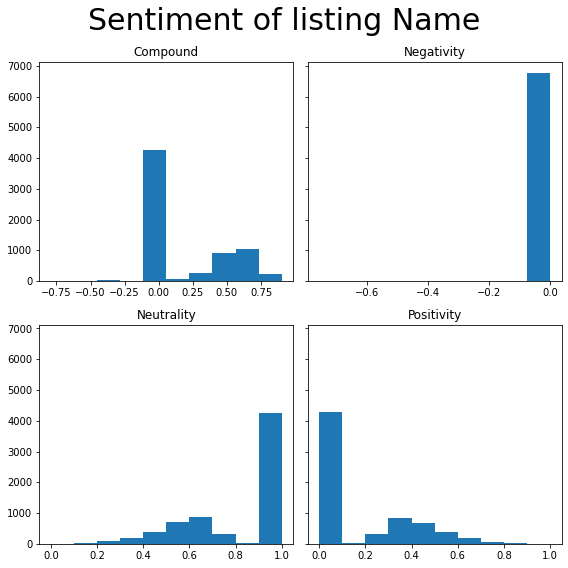

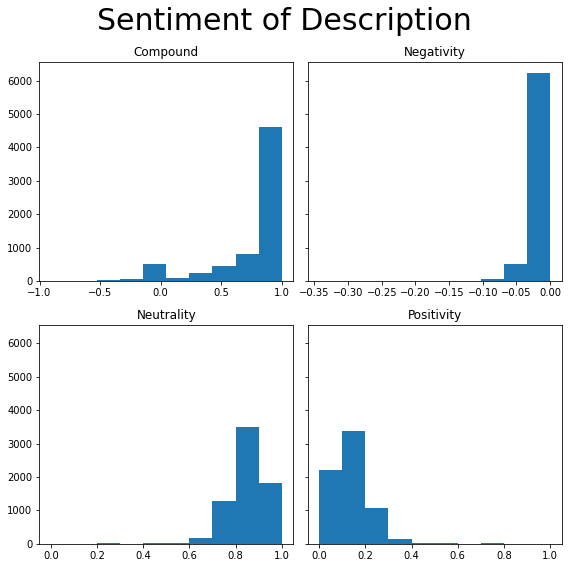

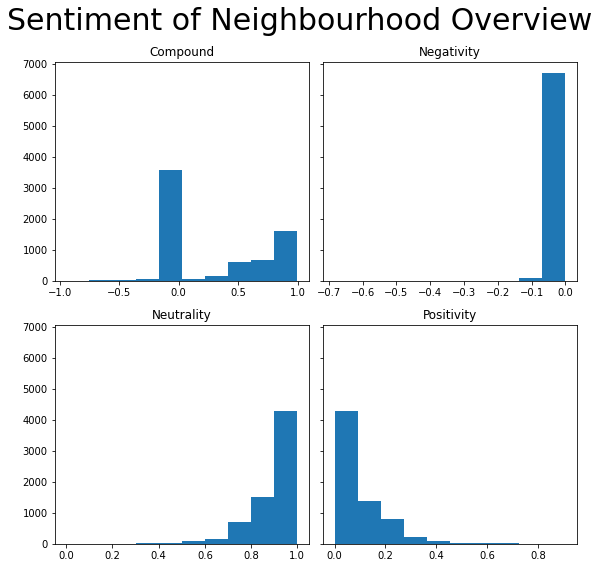

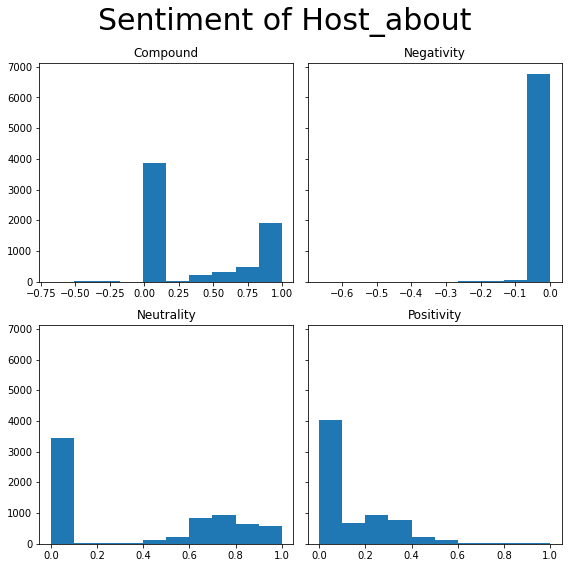

In [110]:
# set figure
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharey=True)
fig.suptitle('Sentiment of listing Name', fontsize=30)
# plot to different axes
ax[0,0].hist(host_sent['compound_name'])
ax[0,0].set_title("Compound")
ax[0,1].hist(-host_sent['negativity_name'])
ax[0,1].set_title("Negativity")
ax[1,0].hist(host_sent['neutrality_name'])
ax[1,0].set_title("Neutrality")
ax[1,1].hist(host_sent['positivity_name'])
ax[1,1].set_title("Positivity")

plt.tight_layout()
plt.show()

# set figure
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharey=True)
fig.suptitle('Sentiment of Description', fontsize=30)
# plot to different axes
ax[0,0].hist(host_sent['compound_descr'])
ax[0,0].set_title("Compound")
ax[0,1].hist(-host_sent['negativity_descr'])
ax[0,1].set_title("Negativity")
ax[1,0].hist(host_sent['neutrality_descr'])
ax[1,0].set_title("Neutrality")
ax[1,1].hist(host_sent['positivity_descr'])
ax[1,1].set_title("Positivity")

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharey=True)
fig.suptitle('Sentiment of Neighbourhood Overview', fontsize=30)
# plot to different axes
ax[0,0].hist(host_sent['compound_neigh_over'])
ax[0,0].set_title("Compound")
ax[0,1].hist(-host_sent['negativity_neigh_over'])
ax[0,1].set_title("Negativity")
ax[1,0].hist(host_sent['neutrality_neigh_over'])
ax[1,0].set_title("Neutrality")
ax[1,1].hist(host_sent['positivity_neigh_over'])
ax[1,1].set_title("Positivity")

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharey=True)
fig.suptitle('Sentiment of Host_about', fontsize=30)
# plot to different axes
ax[0,0].hist(host_sent['compound_host_ab'])
ax[0,0].set_title("Compound")
ax[0,1].hist(-host_sent['negativity_host_ab'])
ax[0,1].set_title("Negativity")
ax[1,0].hist(host_sent['neutrality_host_ab'])
ax[1,0].set_title("Neutrality")
ax[1,1].hist(host_sent['positivity_host_ab'])
ax[1,1].set_title("Positivity")

plt.tight_layout()
plt.show()

In [121]:
host_sent = host_sent.drop(['compound_name', 'negativity_name', 'neutrality_name', 'positivity_name'], axis = 1)

We are done, so drop the text columns

In [128]:
host_sent = host_sent.drop(["name", "descr", "neigh_over", "host_ab"], axis = 1)
host_sent.head(5)
host_sent.to_csv("host_sent_munich.csv")

,id,english_writing_host,compound_descr,negativity_descr,neutrality_descr,positivity_descr,compound_neigh_over,negativity_neigh_over,neutrality_neigh_over,positivity_neigh_over,compound_host_ab,negativity_host_ab,neutrality_host_ab,positivity_host_ab
0,44077,1,0.9808,0.000,0.856,0.144,0.7003,0.057,0.820,0.123,0.9786,0.000,0.584,0.416
1,85156,1,0.9544,0.009,0.895,0.096,0.9906,0.011,0.779,0.210,0.9786,0.000,0.584,0.416
2,159889,1,0.9524,0.000,0.901,0.099,0.5106,0.000,0.784,0.216,0.7164,0.000,0.838,0.162
3,162809,1,0.9867,0.019,0.781,0.200,0.4939,0.000,0.873,0.127,0.9890,0.012,0.826,0.162
4,165828,1,0.9781,0.000,0.839,0.161,0.9274,0.043,0.741,0.216,0.9865,0.007,0.819,0.174


## Host Name

The idea is to check for racism, so we use NamePrism to check which ethnic usually goes hand in hand with a name.
https://name-prism.com/

Six ethnicity/races are considered in our ethnicity classifier: 
White, Black, API (Asian and Pacific Islander), AIAN (American Indian and Alaska Native), 2PRACE (more than 2 race) and Hispanic.

In [3]:
host_names = listings["host_name"]

### The old/own way

In [101]:
names = pd.read_csv("../text_data/name-census-top-100.csv", sep =";")

In [102]:

# due to https://en.wikipedia.org/wiki/Western_Europe#UN_geoscheme_classification
west_europe = ["Austria", "Belgium", "Denmark", "Finland", "France",
               "Germany", "Ireland", "Jersey","Luxembourg", "Netherlands",
               "Norway", "Sweden", "Switzerland", "United Kingdom"]
south_europe = ["Cyprus", "Greece", "Italy", "Portugal", "Spain"]
east_europe = ["Albania", "Belarus", "Bulgaria", "Bosnia and Herzegovina", "Croatia",
               "Czech Republic", "Hungary", "Kosovo", "Latvia", "Lithuania", "Macedonia",
               "Poland", "Romania", "Russia", "Serbia", "Slovakia", "Slovenia", "Ukraine"]

# https://www.worldmap-knowledge.com/articles/the-four-regions-of-asia.html
central_asia = ["Kazakhstan"]
east_asia = ["China", "Hong Kong", "Japan", "South Korea", "Taiwan"]
south_asia = ["Afghanistan", "Bangladesh", "India", "Iran", "Nepal", "Pakistan"]
south_east_asia = ["Indonesia", "Malaysia", "Philippines", "Singapore",
                   "Thailand", "Vietnam"]
west_asia = ["Azerbaijan", "Georgia", "Iraq", "Israel", "Jordan", "Kuwait", "Lebanon",
             "Palestine", "Qatar", "Saudi Arabia", "Syria", "Turkey", "United Arab Emirates"]

oceania = ["Australia", "New Zealand"]

# due to https://de.wikipedia.org/wiki/Geographie_Afrikas
north_africa = ["Algeria", "Egypt", "Morocco", "Sudan", "Tunisia"]
west_africa = ["Burkina Faso", "Ghana", "Ivory Coast", "Liberia", "Nigeria", "Senegal"]
central_africa = ["Angola", "Cameroon"]
east_africa = ["Kenya", "Mayotte", "Zimbabwe", "Somalia", "Tanzania", "Uganda", "Zambia"]

# by feeling and regionale und politische UNterteilung: https://de.wikipedia.org/wiki/Nordamerika
north_america = ["Canada", "United States"]
central_america = ["Bermuda", "Mexico"]
south_central_america = ["Costa Rica", "Dominican Republic", "El Salvador", "Guatemala",
                         "Honduras", "Jamaica", "Nicaragua", "Panama", "Saint Vincent"]

# due to https://de.wikipedia.org/wiki/S%C3%BCdamerika politische Geografie
amazonas = ["Bolivia", "Brazil", "Colombia", "Ecuador", "Peru", "Venezuela"]
conosur = ["Argentina", "Chile", "Paraguay", "Uruguay"]

regions = ["west_europe", "south_europe", "east_europe",
           "central_asia", "east_asia", "south_asia", "south_east_asia",
           "west_asia", "oceania", "north_africa", "west_africa",
           "central_africa", "east_africa", "north_america", "central_america",
           "south_central_america", "amazonas", "conosur", "rare"]

west_europe              4038
south_europe              276
east_europe               381
central_asia                3
east_asia                  95
south_asia                103
south_east_asia            62
west_asia                  84
oceania                     6
north_africa               21
west_africa                42
central_africa              9
east_africa                40
north_america               3
central_america             5
south_central_america      18
amazonas                   12
conosur                     8
rare                     1634
dtype: int64

We found very small groups. One possibility would be grouping by continent.
But wouldn't we expect racism against people potentially not coming from a
Western Culture?
Found categories here https://en.wikipedia.org/wiki/Western_world - and used further sources as mentioned.

In [103]:
import requests
from bs4 import BeautifulSoup

url = 'http://www.namenerds.com/irish/trad.html'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
html_name = soup.select("p td:nth-child(1)")

irish_names = []
for nam in html_name:
    irish_names.append(nam.get_text().split(" ")[0])

further_html_name = soup.select("p td:nth-child(3)")

further_irish_names = []
inb = []
for nam in further_html_name:
    inb = nam.get_text().split(" ")
    for i in range(len(inb)):
        if len(inb[i]) < 3:
            continue
        else:
            further_irish_names.append(inb[i])

trad_irish_names = irish_names + further_irish_names

In [112]:
#https://en.wikipedia.org/wiki/Arab_world
arab = ['Iraq', 'Jordan', 'Kuwait', 'Lebanon', 'Palestine', 'Qatar',
        'Saudi Arabia', 'Syria','United Arab Emirates'] + north_africa
# https://en.wikipedia.org/wiki/Africa but without arab
africa = west_africa + central_africa + east_africa
# https://en.wikipedia.org/wiki/Latin_America
latin_america = ["Mexico"] + south_central_america + amazonas + conosur
# https://en.wikipedia.org/wiki/Western_world#Modern_definitions
west = ['Bermuda', 'Bulgaria', 'Croatia', 'Czech Republic', 'Hungary', 'Latvia',
        'Lithuania', 'Poland', 'Romania', 'Slovakia', 'Slovenia'] \
       + oceania + north_america + west_europe + south_europe
# https://en.wikipedia.org/wiki/Eastern_Orthodoxy_by_country
eastern_europe = ['Albania', 'Belarus', 'Bosnia and Herzegovina',
            'Kosovo', 'Macedonia', 'Russia', 'Serbia', 'Ukraine']
asia = central_asia + east_asia + south_asia + south_east_asia \
       + ['Azerbaijan', 'Georgia', 'Israel',  'Turkey']


cult_regions = ["trad_irish", "arab", "africa", "asia", "eastern_europe", "latin_america", "west", "rare"]

where_df_cult = pd.DataFrame(0, index=np.arange(len(listings)), columns=cult_regions)


# Now real loop
for i in range(len(host_names)):
    single_name = host_names.loc[i].split()[0]
    single_name = single_name.split("&")[0]
    single_name = single_name.split("-")[0]
    if single_name in trad_irish_names:
        where_df_cult.at[i, "trad_irish"] = 1
    else:
        und_df = names[single_name == names["Name"]][["Country name", "Country Rank"]]
        if len(und_df) == 0:
            where_df_cult.at[i, "rare"] = 1
        elif any(country in west for country in und_df["Country name"]):
            where_df_cult.at[i, "west"] = 1
        else:
            con = und_df.loc[und_df["Country Rank"].idxmax(),]["Country name"]
            if any(country in arab for country in und_df["Country name"]):
                where_df_cult.at[i, "arab"] = 1
            elif any(country in africa for country in und_df["Country name"]):
                where_df_cult.at[i, "africa"] = 1
            elif any(country in asia for country in und_df["Country name"]):
                where_df_cult.at[i, "asia"] = 1
            elif any(country in eastern_europe for country in und_df["Country name"]):
                where_df_cult.at[i, "eastern_europe"] = 1
            elif any(country in latin_america for country in und_df["Country name"]):
                where_df_cult.at[i, "latin_america"] = 1
            else:
                where_df_cult.at[i, "rare"] = 1

# Let's this categorisation
where_df_cult.sum()

trad_irish         545
arab               109
africa             141
asia               173
eastern_europe      23
latin_america       42
west              4271
rare              1536
dtype: int64

What are the rare names?

In [114]:
where_df_cult = where_df_cult.add_prefix('host_name_sounds_')
where_df_cult

,host_name_sounds_trad_irish,host_name_sounds_arab,host_name_sounds_africa,host_name_sounds_asia,host_name_sounds_eastern_europe,host_name_sounds_latin_america,host_name_sounds_west,host_name_sounds_rare
0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
6835,0,0,0,0,0,0,1,0
6836,0,0,1,0,0,0,0,0
6837,0,0,0,0,0,0,1,0
6838,0,0,0,0,0,0,1,0


In [ ]:
where_df_cult.to_csv("host_name_munich.csv")